In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
import torch.optim as optim

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from src.visualization.toy_example import plot_moons, plot_multiclass, show_density_grid, show_acquisition_grid
from src.data.toy_example import generate_moons, generate_multiclass
from src.methods.target_input_distribution import MultivariateGaussian

from src.models.utils import GP_sample
from src.methods.toy_example import run_active_learning_loop_toy

from src.models.llla import SimpleLLLA
from src.methods.acquisition_functions import Entropy, BALD

In [20]:

    # # Generate initial points
    # Xtrain, ytrain = make_moons(N_initial_per_class * 2, noise=noise, random_state=0)
    # Xtrain, ytrain = np.vstack([Xtrain[ytrain == 0][:N_initial_per_class], Xtrain[ytrain == 1][:N_initial_per_class]]), np.hstack([ytrain[ytrain == 0][:N_initial_per_class], ytrain[ytrain == 1][:N_initial_per_class]])

    # # Generate moons dataset
    # X_, y_ = make_moons(N_test + N_pool, noise=noise, random_state=0)
    
    # # Generate pool and test sets
    # Xtest,  ytest   = X_[:N_test], y_[:N_test]
    # Xpool,  ypool   = X_[N_test:], y_[N_test:]

In [2]:
def plot_example(model, Xtrain, Xtest, Xpool, ytrain, ytest, acq_fun, next_query, P=150, zoom=None, auto_zoom=True):
    
    ### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)

    # Plot model uncertainty across grid
    axs[0], density_grid_output = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, P=P, auto_zoom=auto_zoom, zoom=zoom, ax=axs[0], fig=fig)
    axs[0].legend()

    decisions_bls = np.argmax(density_grid_output[2], axis=1).reshape((len(density_grid_output[0]), len(density_grid_output[1])))
    axs[1].pcolormesh(density_grid_output[0], density_grid_output[1], 1-decisions_bls, alpha=0.8, cmap=plt.cm.RdBu_r, shading='auto')        
    axs[1].set_title('Decision boundary')
    axs[1].set_xlabel('$x_1$')
    axs[1].grid(None)

    # Plot acquisition function across a grid
    axs[2] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, density_grid_output, P=P, auto_zoom=auto_zoom, zoom=zoom, ax=axs[2], fig=fig)
    axs[2].scatter(next_query[0], next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
    axs[2].legend()
    return axs

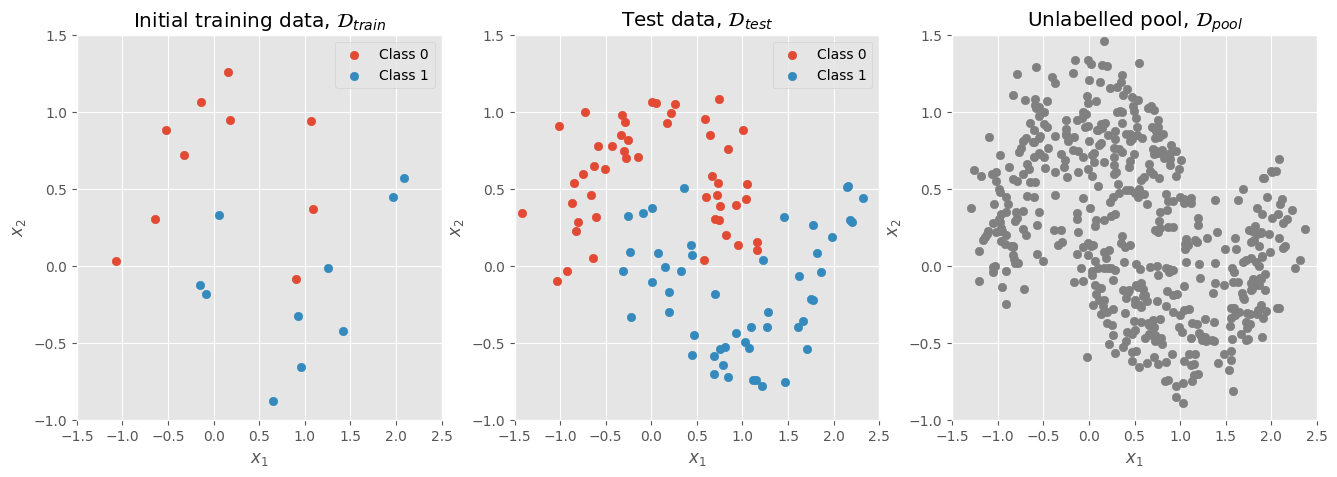

In [5]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 10
N_test      = 100
N_pool      = 500
num_classes = 2

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_moons(N_initial_per_class=N_initial, N_test=N_test, N_pool=N_pool, noise=0.2)

# Plot the dataset partitions
plot_moons(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

# Set device
device = torch.device('cpu') #torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Xtrain  = torch.FloatTensor(Xtrain).to(device)
Xtest   = torch.FloatTensor(Xtest).to(device)
Xpool   = torch.FloatTensor(Xpool).to(device)

ytrain  = torch.LongTensor(ytrain).to(device)
ytest   = torch.LongTensor(ytest).to(device)
ypool   = torch.LongTensor(ypool).to(device)

In [27]:

def generate_multiclass(N_initial_per_class, N_test, N_pool, num_classes=4, noise=0.075):

    # Generate initial points
    Xtrain, ytrain = make_blobs(n_samples=N_initial_per_class * num_classes, centers=num_classes, cluster_std=noise, center_box=(-3, 3), random_state=0) 
    Xtrain, ytrain  = np.vstack([Xtrain[ytrain == i][:N_initial_per_class] for i in range(num_classes)]), np.hstack([ytrain[ytrain == i][:N_initial_per_class] for i in range(num_classes)])

    # Generate moons dataset
    X_, y_ = make_blobs(n_samples=N_test + N_pool, centers=num_classes, cluster_std=noise, center_box=(-3, 3), random_state=0) 
    
    # Generate pool and test sets
    Xtest,  ytest   = X_[:N_test], y_[:N_test]
    Xpool,  ypool   = X_[N_test:], y_[N_test:]

    return Xtrain, ytrain, Xtest, ytest, Xpool, ypool

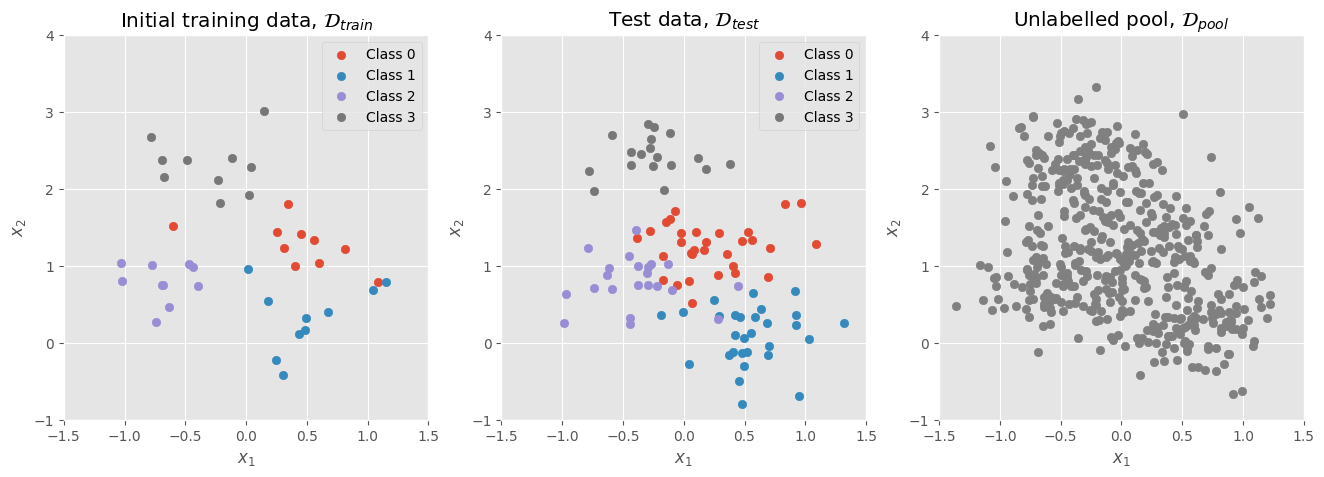

In [29]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 10
N_test      = 100
N_pool      = 500
num_classes = 2

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_multiclass(N_initial_per_class=N_initial, N_test=N_test, N_pool=N_pool, noise=0.35)

# Plot the dataset partitions
plot_multiclass(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

# Set device
device = torch.device('cpu') #torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Xtrain  = torch.FloatTensor(Xtrain).to(device)
Xtest   = torch.FloatTensor(Xtest).to(device)
Xpool   = torch.FloatTensor(Xpool).to(device)

ytrain  = torch.LongTensor(ytrain).to(device)
ytest   = torch.LongTensor(ytest).to(device)
ypool   = torch.LongTensor(ypool).to(device)

In [5]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from types import MethodType

model           = GaussianProcessClassifier(1.0 * RBF(1.0))
model.sample    = MethodType( GP_sample, model )

model.fit_       = MethodType(  lambda self, Xtrain, ytrain, Xval, yval: self.fit(Xtrain, ytrain) , model )
model.fit_(Xtrain=Xtrain, ytrain=ytrain, Xval=Xtest, yval=ytest)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [6]:
# Define parameters
lr          = 1e-4
epochs      = 100
val_step    = 1
seed        = 0

# Define model
model = SimpleLLLA(num_classes=num_classes, n_posterior_samples=1000, lr=lr, epochs=epochs, val_step=val_step, seed=seed)

# Fit model
model.fit_(Xtrain, ytrain, Xtest, ytest)

EPOCH 1000/1000: Train acc. = 1.0000 	 | Validation acc. = 0.9100 	 | Train loss = 0.0599 	 | Validation loss = 0.2686: 100%|██████████| 1000/1000 [00:09<00:00, 102.67it/s]

BEST EPOCH = 996


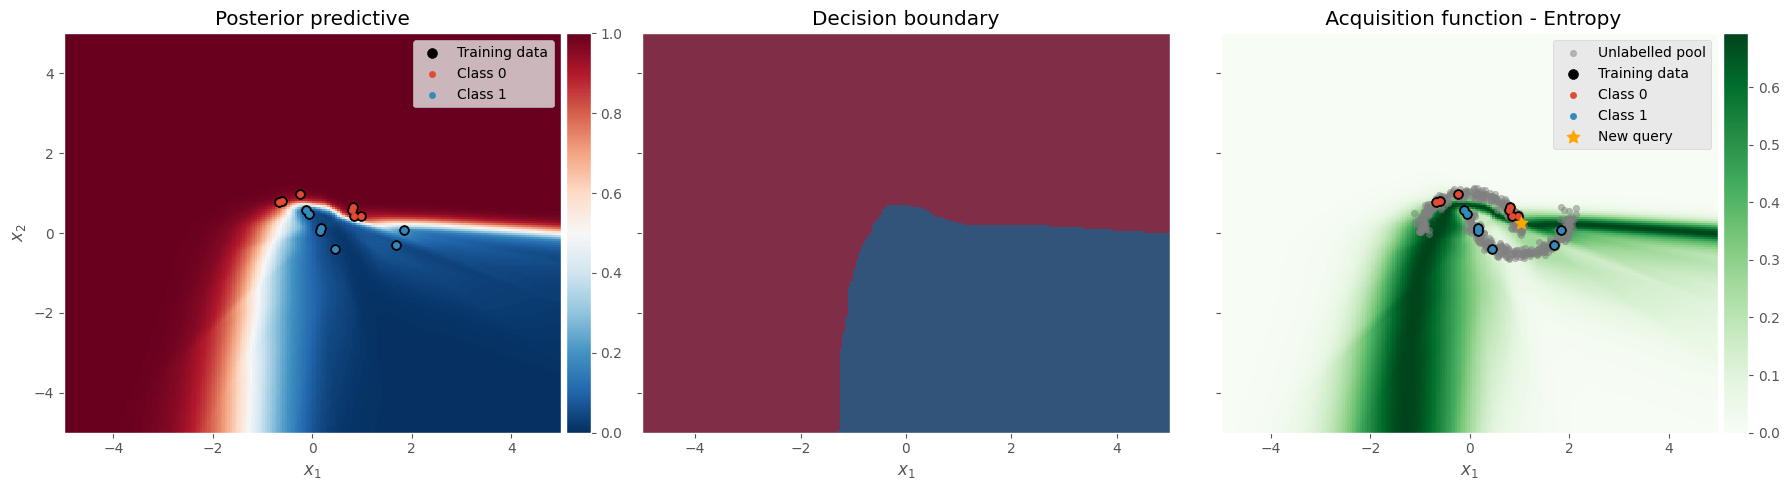

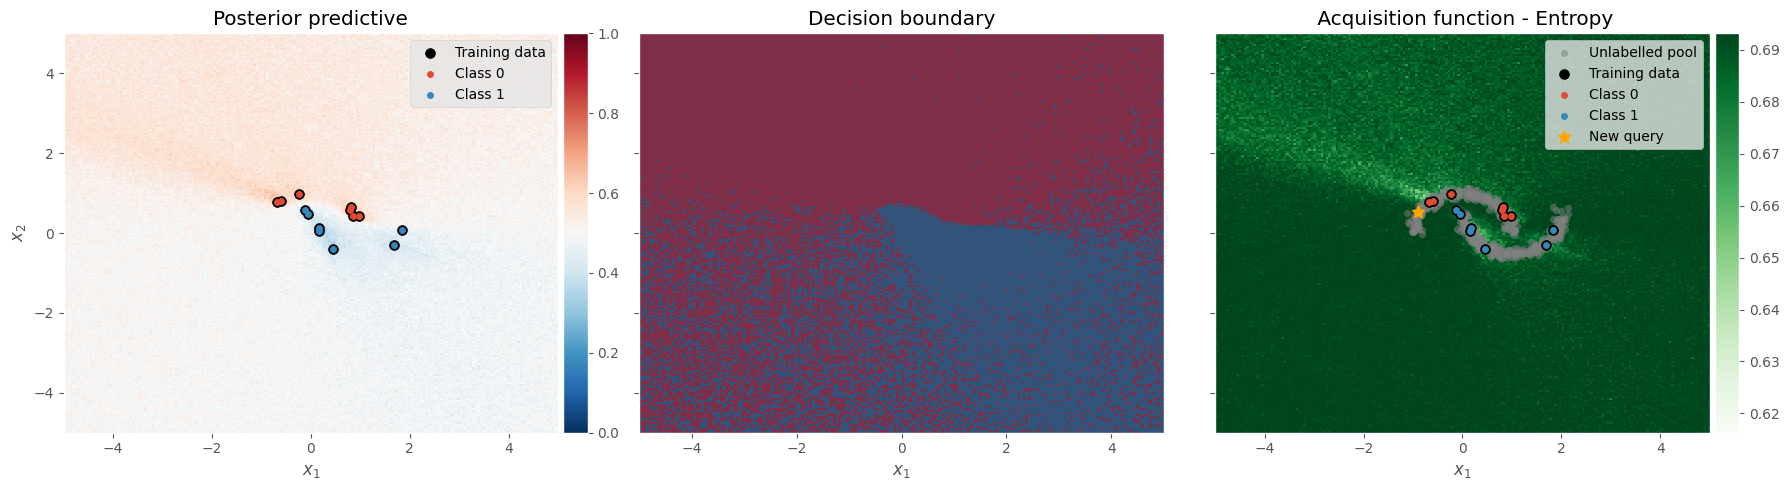

In [7]:
model.predict_proba = model.predict_MAP_proba
with torch.no_grad():
    # Define acquisition function
    acq_fun         = Entropy(query_n_points=None)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    axs = plot_example(model, Xtrain, Xtest, Xpool, ytrain, ytest, acq_fun, next_query, P=200, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
    plt.tight_layout()
    plt.show()

model.predict_proba = model.predict_posterior_proba
with torch.no_grad():
    # Define acquisition function
    acq_fun         = Entropy(query_n_points=None)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    axs = plot_example(model, Xtrain, Xtest, Xpool, ytrain, ytest, acq_fun, next_query, P=200, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
    plt.tight_layout()
    plt.show()

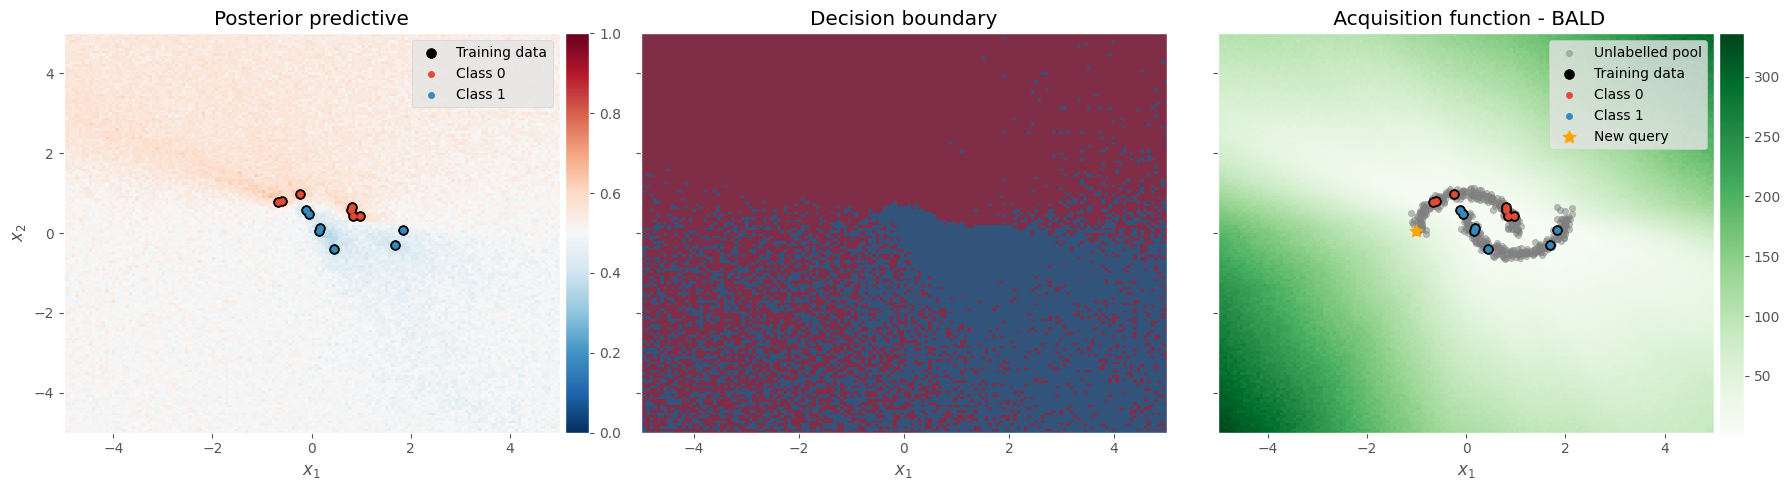

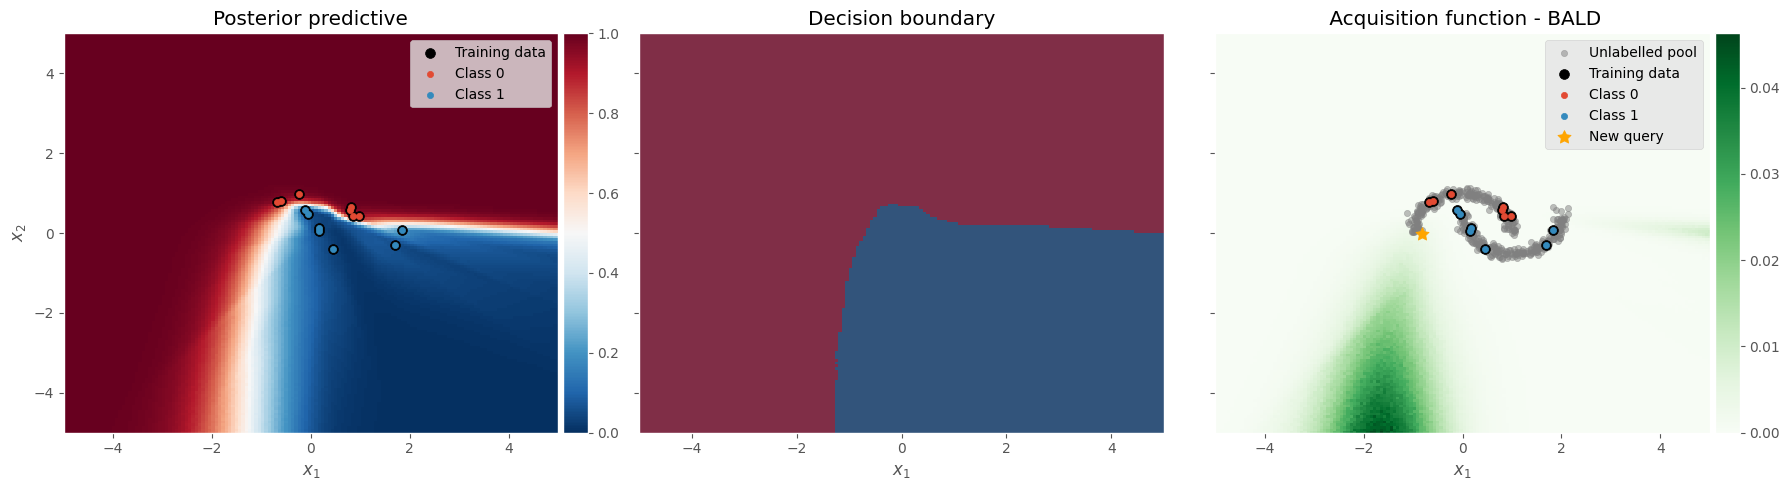

In [8]:
model.predict_proba     = model.predict_posterior_proba
model.variance_factor   = 1.
with torch.no_grad():
    # Define acquisition function
    acq_fun         = BALD(query_n_points=None, n_posterior_samples=2000)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    axs = plot_example(model, Xtrain, Xtest, Xpool, ytrain, ytest, acq_fun, next_query, P=150, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
    plt.tight_layout()
    plt.show()

model.variance_factor   = 1e-6
with torch.no_grad():
    # Define acquisition function
    acq_fun         = BALD(query_n_points=None, n_posterior_samples=2000)

    # Get acquisition function score and the items to query
    _, query_idxs   = acq_fun(Xpool, model=model)
    next_query      = Xpool[query_idxs[0]]

    # Visualize
    axs = plot_example(model, Xtrain, Xtest, Xpool, ytrain, ytest, acq_fun, next_query, P=150, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
    plt.tight_layout()
    plt.show()

In [14]:
# from src.methods.acquisition_functions import AcquisitionFunction
# from src.methods.target_input_distribution import TargetInputDistribution
# from typing import Tuple

# class MyEPIG(AcquisitionFunction):

#     def __init__(self, query_n_points, target_input_distribution: TargetInputDistribution, n_posterior_samples: int = 1000, n_target_input_samples: int = 100, seed: int = 0):
#         # Make target-input distribution accesible
#         self.target_input_distribution = target_input_distribution

#         # Set class-wide sampling parameters
#         self.n_posterior_samples    = n_posterior_samples
#         self.n_target_input_samples = n_target_input_samples
#         self.seed                   = seed

#         super().__init__(name='MyEPIG', query_n_points=query_n_points)

#     def __call__(self, Xpool: np.ndarray, return_sorted: bool = True, **kwargs) -> Tuple[np.ndarray, np.ndarray]:

#         # Sample x* values from the target input distribution
#         Xstar                   = self.target_input_distribution.sample(self.n_target_input_samples, seed=self.seed)
        
#         # Extract predictive probabilities for target samples and all points in the pool by exploiting Monte Carlo sampling of the posterior
#         posterior_pool_samples      = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed)
#         posterior_target_samples    = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed)

#         pool_probs                  = torch.softmax(posterior_pool_samples, dim=0) #.mean(axis=1).T  
#         targ_probs                  = torch.softmax(posterior_target_samples, dim=0)# .mean(axis=1).T  

#         # Define constants
#         num_classes = pool_probs.shape[0]
#         K, M        = self.n_posterior_samples, self.n_target_input_samples

#         # Compute the joint term of the expression (summation on the numerator part of the fraction in the log)
#         joint_term          = torch.tensor(np.array([[((pool_probs[c, :, :] * targ_probs[c_star, :, j][:, None]).sum(axis=0)).cpu().numpy() for j in range(M)] for c in range(num_classes) for c_star in range(num_classes)]))
#         # Compute the independent term of the expression (summation on the denominator part of the fraction in the log)
#         independent_term    = torch.tensor(np.array([[(pool_probs[c, :, :].sum(axis=0) * targ_probs[c_star, :, j].sum(axis=0)).cpu().numpy() for j in range(M)] for c in range(num_classes) for c_star in range(num_classes)]))
#         # Compute log-term
#         log_term            = np.log(K * joint_term) - np.log(independent_term)
#         # Wrap it up and compute the final acquisition scores
#         acq_scores          = 1/M * log_term.sum(axis=(1, 0))

#         # Sort values
#         return self.order_acq_scores(acq_scores=acq_scores, return_sorted=return_sorted)
    
# model.variance_factor   = 1.
# model.predict_proba     = model.predict_posterior_proba

# for mu in [[-1.5, 1.5], [1.5, -1.5], [-1.5, -1.5], [1.5, 1.5], [-1.5, 0.0], [1.5, 0.0]]:
#     with torch.no_grad():
#         # Define acquisition function
#         target_input_dist = MultivariateGaussian(mu=mu, Sigma=np.eye(2) / 4)

#         # Define acquisition function
#         acq_fun = MyEPIG(
#             query_n_points=None, 
#             target_input_distribution=target_input_dist,
#             n_posterior_samples=100,
#             n_target_input_samples=5,
#         )

#         # Get acquisition function score and the items to query
#         _, query_idxs   = acq_fun(Xpool, model=model)
#         next_query      = Xpool[query_idxs[0]]

#         # Visualize
#         axs = plot_example(acq_fun, next_query, P=55, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
#         # Plot target input distribution on top
#         target_input_dist.plot_2D(ax=axs[2], zoom=([-5, 5], [-5, 5]))

#         plt.tight_layout()
#         plt.show()

\begin{align*}
    \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) &=  \sum_{i=0}^K \exp \log \biggl(p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i)\biggr) \\
    &= \sum_{i=0}^K \exp \biggl(\log p(y = c | x, \theta_i) + \log p(y^\ast = c | x^\ast_j, \theta_i)\biggr) \\
    &= \sum_{i=0}^K \exp \biggl(\log \frac{e^{z_c}}{\sum_{j \in \mathcal{Y}}{e^{z_j}}} + \log \frac{e^{z_c^\ast}}{\sum_{j \in \mathcal{Y^\ast}}{e^{z_j}}}\biggr) \\
    &= \sum_{i=0}^K \exp \biggl(z_c - \log \sum_{j \in \mathcal{Y}}{e^{z_j}} + z_c^\ast - \log \sum_{j \in \mathcal{Y^\ast}}{e^{z_j}} \biggr) \\
    &= \sum_{i=0}^K \exp \biggl(z_c + z_c^\ast - \log \sum_{j \in \mathcal{Y}}{e^{z_j}} - \log \sum_{j \in \mathcal{Y^\ast}}{e^{z_j}} \biggr) \\
\end{align*}

\begin{align*}
    \log \frac{\frac{\sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i)}{K}}{\frac{\sum_{i=0}^K p(y = c | x, \theta_i)}{K}  \frac{\sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i)}{K}} &= \log \frac{\sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i)}{K} - \log \biggl({\frac{\sum_{i=0}^K p(y = c | x, \theta_i)}{K}  \frac{\sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i)}{K}}\biggr) \\
    &= \log \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) - \log K - \biggl( \log  \frac{\sum_{i=0}^K p(y = c | x, \theta_i)}{K} + \log \frac{\sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i)}{K} \biggr) \\
    &= \log \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) - \log K - \biggl( \log  \sum_{i=0}^K p(y = c | x, \theta_i) - \log K + \log \sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i) - \log K \biggr) \\
    &= \log \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) - \log K - \log  \sum_{i=0}^K p(y = c | x, \theta_i) - \log \sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i) + 2 \log K \\
    &= \log \sum_{i=0}^K p(y = c | x, \theta_i) p(y^\ast = c | x^\ast_j, \theta_i) - \log  \sum_{i=0}^K p(y = c | x, \theta_i) - \log \sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i) + \log K \\
    &= \log \sum_{i=0}^K \exp \biggl(z_c + z_c^\ast - \log \sum_{j \in \mathcal{Y}}{e^{z_j}} - \log \sum_{j \in \mathcal{Y^\ast}}{e^{z_j}} \biggr) - \log  \sum_{i=0}^K p(y = c | x, \theta_i) - \log \sum_{i=0}^K p(y^\ast = c | x^\ast_j, \theta_i) + \log K \\
\end{align*}

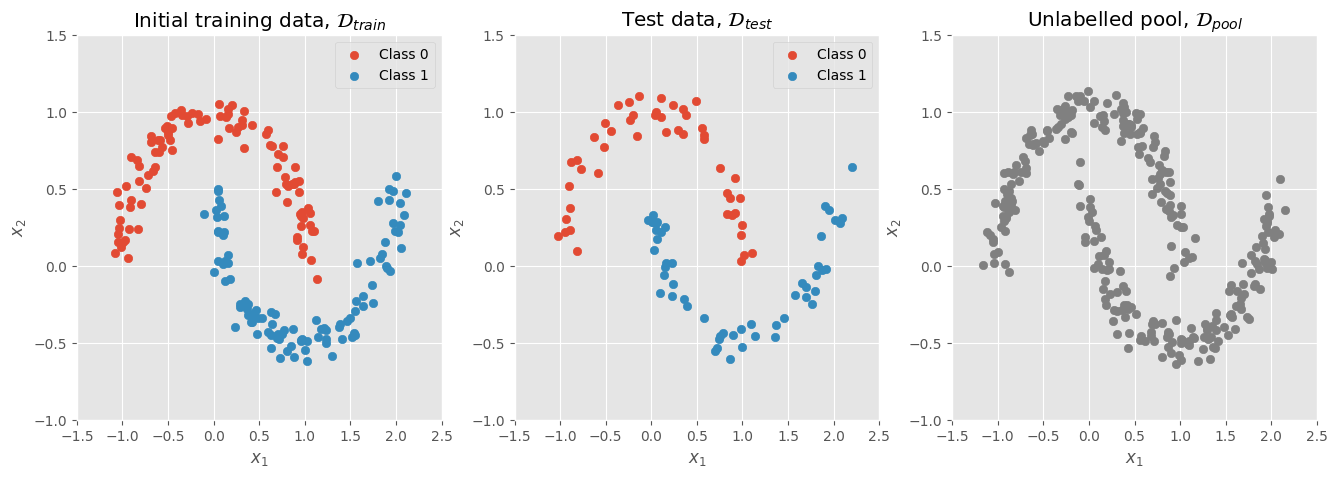

EPOCH 4000/4000: Train acc. = 1.0000 	 | Validation acc. = 1.0000 	 | Train loss = 0.0021 	 | Validation loss = 0.0021: 100%|██████████| 4000/4000 [00:31<00:00, 128.87it/s]


BEST EPOCH = 3999


In [98]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 100
N_test      = 100
N_pool      = 500
num_classes = 2

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_moons(N_initial_per_class=N_initial, N_test=N_test, N_pool=N_pool)

# Plot the dataset partitions
plot_moons(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

# Set device
device = torch.device('cpu') #torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Xtrain  = torch.FloatTensor(Xtrain).to(device)
Xtest   = torch.FloatTensor(Xtest).to(device)
Xpool   = torch.FloatTensor(Xpool).to(device)

ytrain  = torch.LongTensor(ytrain).to(device)
ytest   = torch.LongTensor(ytest).to(device)
ypool   = torch.LongTensor(ypool).to(device)

# Define parameters
lr          = 1e-4
epochs      = 4000
val_step    = 1
seed        = 0

# Set device for model
model = SimpleLLLA(alpha=1., n_posterior_samples=5000)
model.to(device)

optimizer   = optim.Adam(model.parameters(), lr=lr)

train_model(model, optimizer, Xtrain, ytrain, Xtest, ytest, epochs, val_step, seed)

# "train" LLLA 
model.fit_LLLA(Xtrain, ytrain)

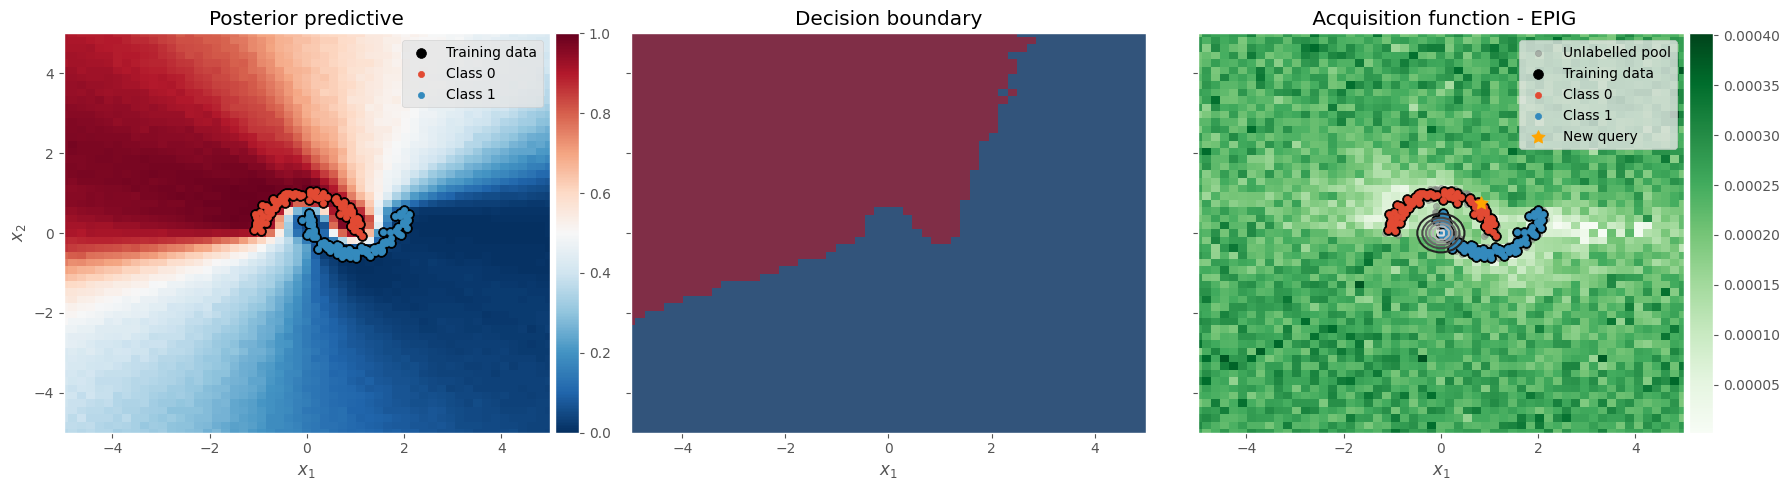

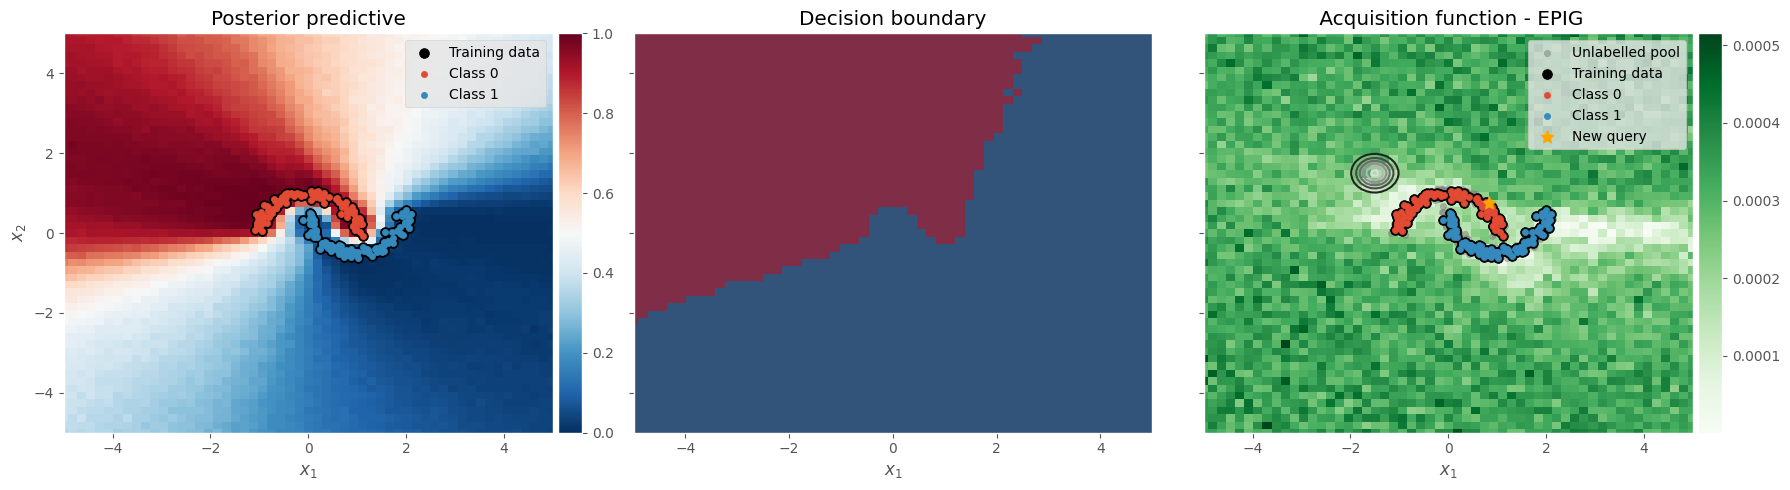

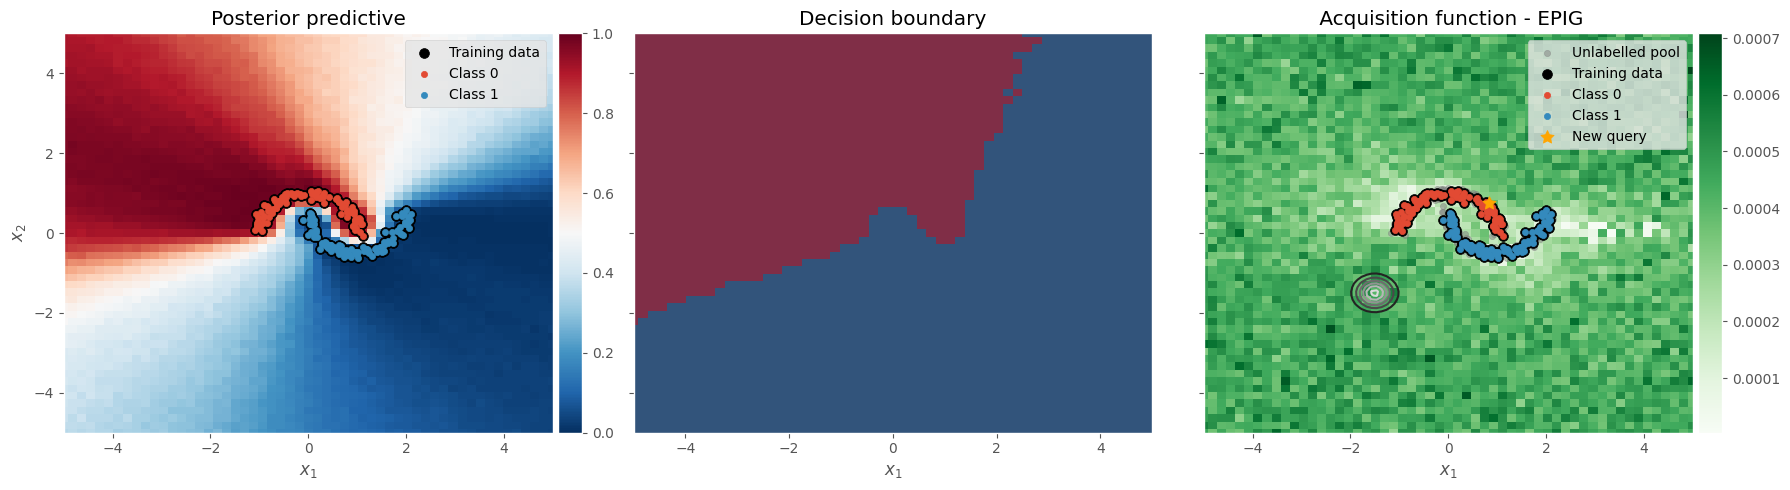

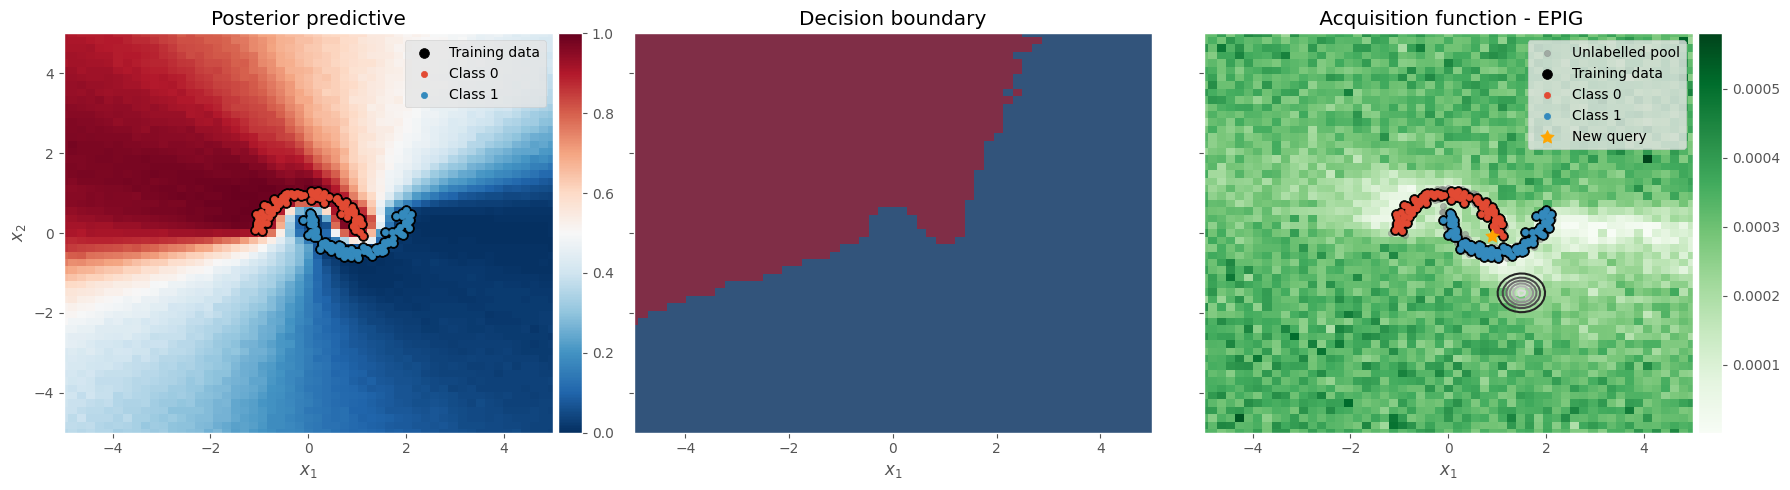

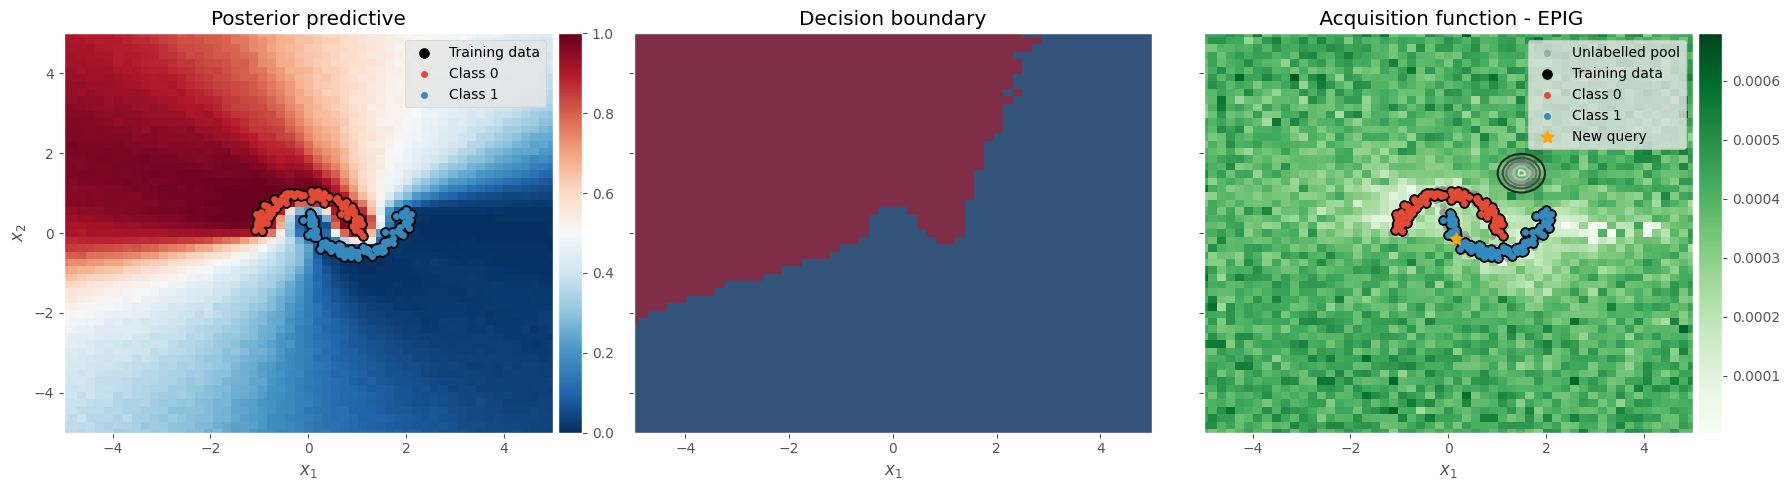

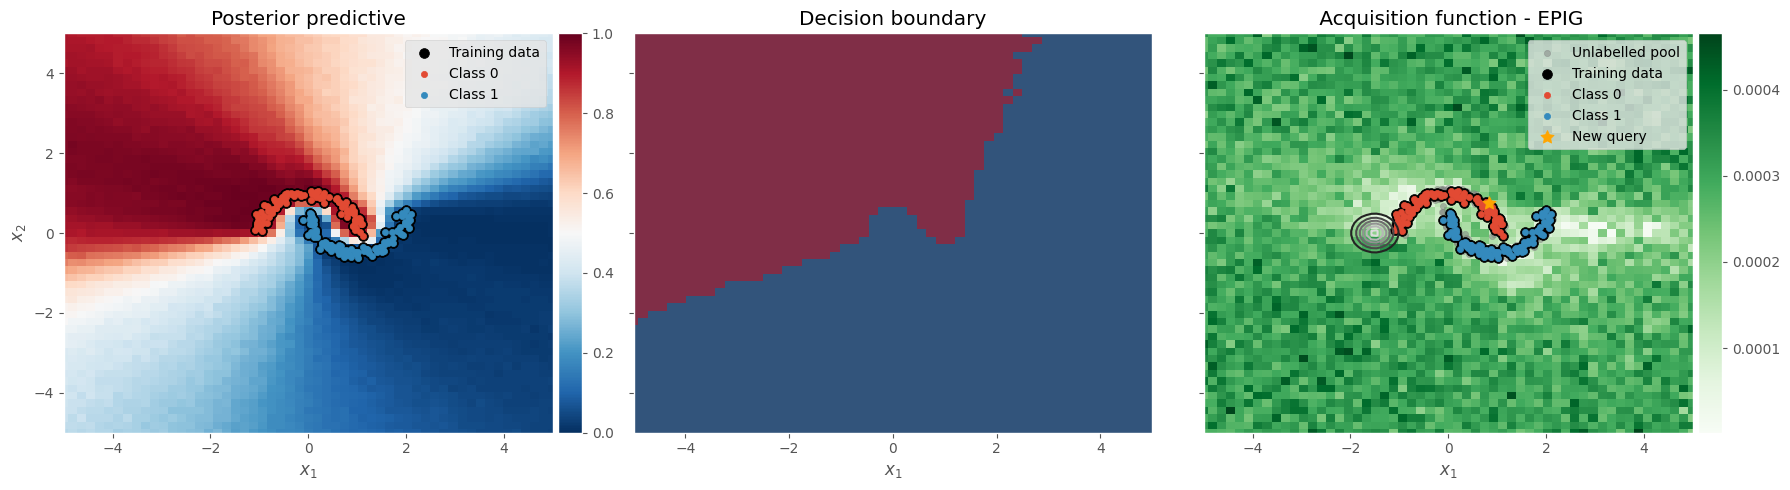

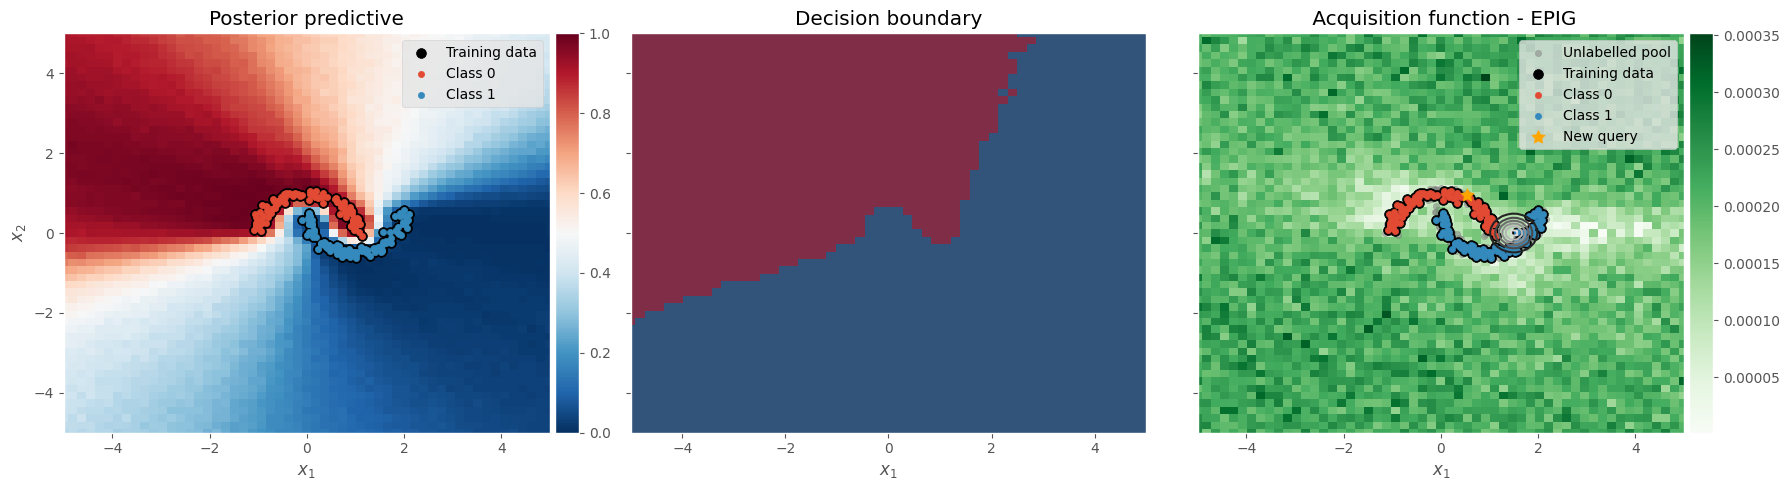

In [99]:
from src.methods.acquisition_functions import AcquisitionFunction
from src.methods.target_input_distribution import TargetInputDistribution
from typing import Tuple
import math

class EPIG(AcquisitionFunction):

    def __init__(self, query_n_points, target_input_distribution: TargetInputDistribution, n_posterior_samples: int = 1000, n_target_input_samples: int = 100, seed: int = 0):
        # Make target-input distribution accesible
        self.target_input_distribution = target_input_distribution

        # Set class-wide sampling parameters
        self.n_posterior_samples    = n_posterior_samples
        self.n_target_input_samples = n_target_input_samples
        self.seed                   = seed

        super().__init__(name='EPIG', query_n_points=query_n_points)

    def __call__(self, Xpool: np.ndarray, return_sorted: bool = True, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        K, M        = self.n_posterior_samples, self.n_target_input_samples

        # Sample x* values from the target input distribution
        Xstar                       = self.target_input_distribution.sample(self.n_target_input_samples, seed=self.seed)
        self.Xstar                  = Xstar

        # Extract predictive probabilities for target samples and all points in the pool by exploiting Monte Carlo sampling of the posterior
        posterior_pool_samples      = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed)
        posterior_target_samples    = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed)

        logprobs_pool               = torch.log_softmax(posterior_pool_samples, dim=0)[:, None, :, :, None]
        logprobs_target             = torch.log_softmax(posterior_target_samples, dim=0)[None, :, :, None, :]

        logprobs_joint              = logprobs_pool + logprobs_target
        logprobs_joint              = torch.logsumexp(logprobs_joint, dim=2) - math.log(K)
        probs_joint                 = torch.exp(logprobs_joint)

        logprobs_independent        = (torch.logsumexp(logprobs_pool, dim=2) - math.log(K)) + (torch.logsumexp(logprobs_target, dim=2) - math.log(K))
        log_term                    = logprobs_joint - logprobs_independent

        acq_scores                  = (probs_joint * log_term).sum(dim=[0, 1])
        acq_scores                  = acq_scores.mean(dim=-1)
        assert torch.all((acq_scores + 1e-6 >= 0) & (acq_scores - 1e-6 <= math.inf)).item(), "Acquisition scores are not valid!"
        
        # Sort values
        return self.order_acq_scores(acq_scores=acq_scores, return_sorted=return_sorted)
    
model.variance_factor   = 1.
model.predict_proba     = model.predict_posterior_proba

for mu in [[0.0, 0.0], [-1.5, 1.5], [-1.5, -1.5], [1.5, -1.5], [1.5, 1.5], [-1.5, 0.0], [1.5, 0.0]]:
    with torch.no_grad():
        # Define acquisition function
        target_input_dist = MultivariateGaussian(mu=mu, Sigma=np.eye(2) / 4)

        # Define acquisition function
        acq_fun = EPIG(
            query_n_points=None, 
            target_input_distribution=target_input_dist,
            n_posterior_samples=1000,
            n_target_input_samples=100,
            seed=0
        )

        # Get acquisition function score and the items to query
        _, query_idxs   = acq_fun(Xpool, model=model)
        next_query      = Xpool[query_idxs[0]]

        # Visualize
        axs = plot_example(acq_fun, next_query, P=55, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
        # axs[2].scatter(acq_fun.Xstar[:, 0], acq_fun.Xstar[:, 1], marker='s', s=50, color='k')
        # Plot target input distribution on top
        target_input_dist.plot_2D(ax=axs[2], zoom=([-5, 5], [-5, 5]))

        plt.tight_layout()
        plt.show()

In [ ]:
# TODO: 1D problem 

### BLOBS

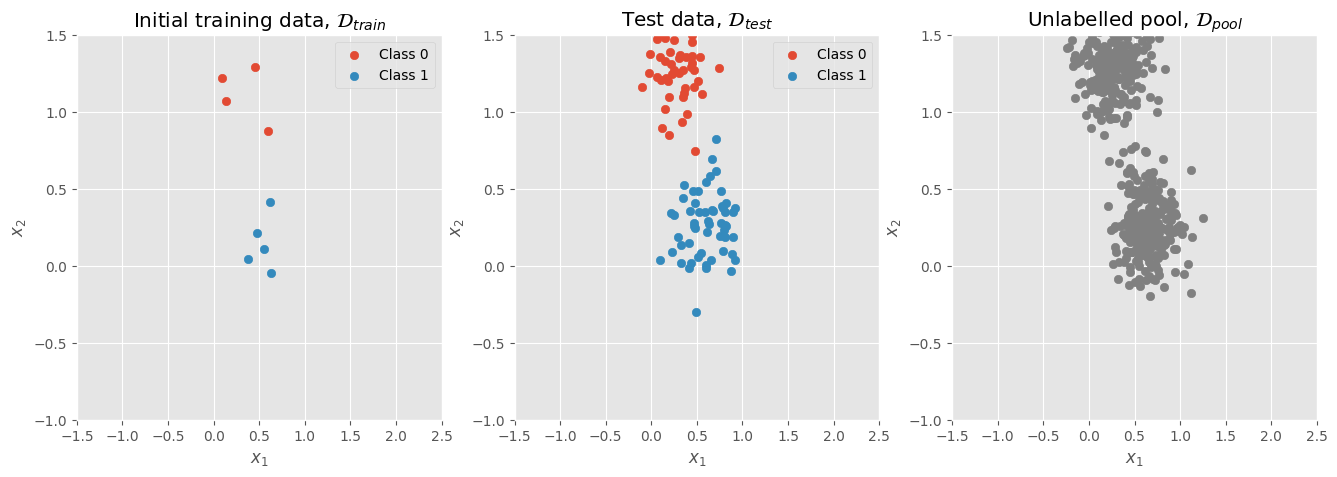

EPOCH 2000/2000: Train acc. = 1.0000 	 | Validation acc. = 0.9800 	 | Train loss = 0.0114 	 | Validation loss = 0.0901: 100%|██████████| 2000/2000 [00:17<00:00, 113.19it/s]


BEST EPOCH = 1999


In [100]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 5
N_test      = 100
N_pool      = 500
num_classes = 2

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_multiclass(N_initial_per_class=N_initial, N_test=N_test, N_pool=N_pool, num_classes=num_classes, noise=0.2)

# Plot the dataset partitions
plot_moons(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

# Set device
device = torch.device('cpu') #torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Xtrain  = torch.FloatTensor(Xtrain).to(device)
Xtest   = torch.FloatTensor(Xtest).to(device)
Xpool   = torch.FloatTensor(Xpool).to(device)

ytrain  = torch.LongTensor(ytrain).to(device)
ytest   = torch.LongTensor(ytest).to(device)
ypool   = torch.LongTensor(ypool).to(device)

# Define parameters
lr          = 1e-4
epochs      = 2000
val_step    = 1
seed        = 0

# Set device for model
model = SimpleLLLA(alpha=1., n_posterior_samples=5000)
model.to(device)

optimizer   = optim.Adam(model.parameters(), lr=lr)

train_model(model, optimizer, Xtrain, ytrain, Xtest, ytest, epochs, val_step, seed)

# "train" LLLA 
model.fit_LLLA(Xtrain, ytrain)

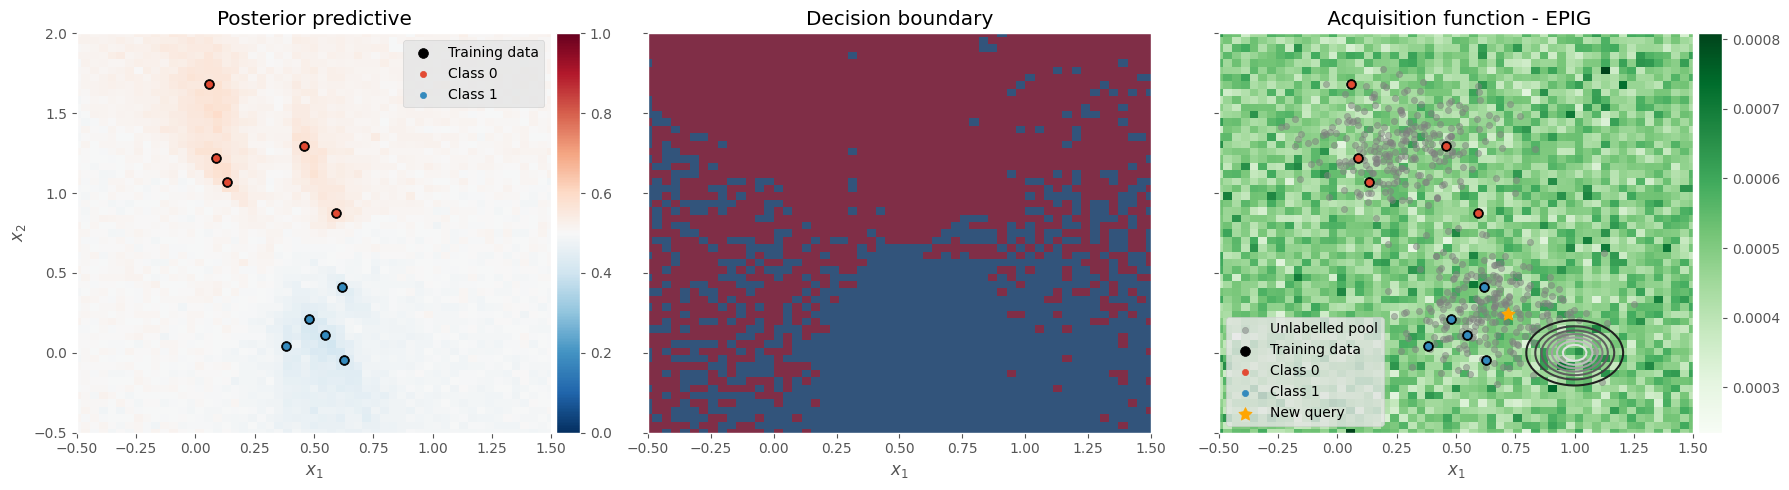

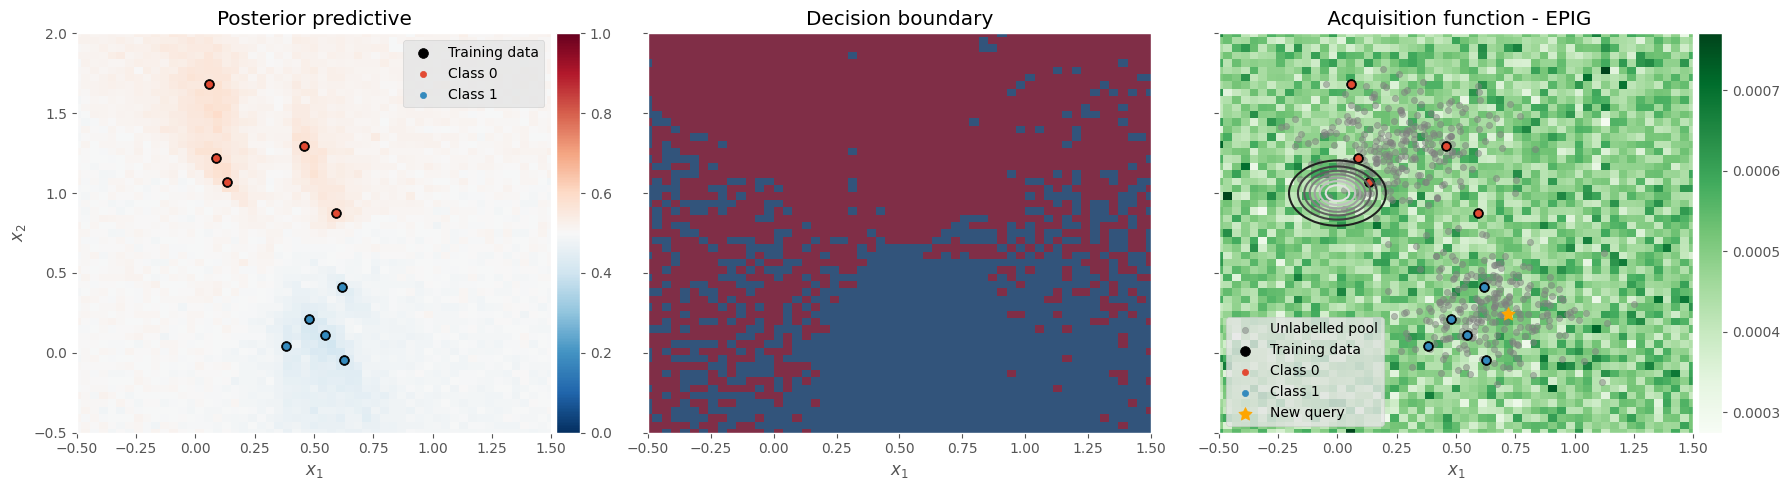

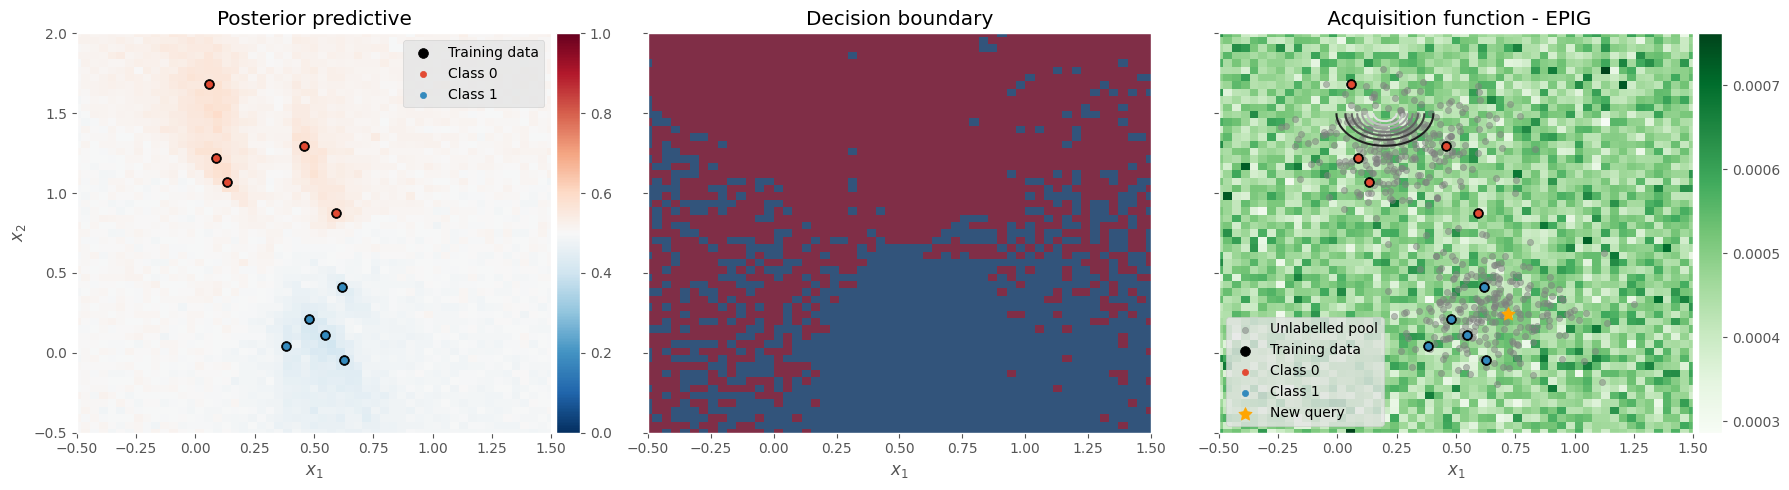

In [101]:
from src.methods.acquisition_functions import AcquisitionFunction
from src.methods.target_input_distribution import TargetInputDistribution
from typing import Tuple
import math

class EPIG(AcquisitionFunction):

    def __init__(self, query_n_points, target_input_distribution: TargetInputDistribution, n_posterior_samples: int = 1000, n_target_input_samples: int = 100, seed: int = 0):
        # Make target-input distribution accesible
        self.target_input_distribution = target_input_distribution

        # Set class-wide sampling parameters
        self.n_posterior_samples    = n_posterior_samples
        self.n_target_input_samples = n_target_input_samples
        self.seed                   = seed

        super().__init__(name='EPIG', query_n_points=query_n_points)

    def __call__(self, Xpool: np.ndarray, return_sorted: bool = True, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        K, M        = self.n_posterior_samples, self.n_target_input_samples

        # Sample x* values from the target input distribution
        Xstar                       = self.target_input_distribution.sample(self.n_target_input_samples, seed=self.seed)
        self.Xstar                  = Xstar

        # Extract predictive probabilities for target samples and all points in the pool by exploiting Monte Carlo sampling of the posterior
        posterior_pool_samples      = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed)
        posterior_target_samples    = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed)

        logprobs_pool               = torch.log_softmax(posterior_pool_samples, dim=0)[:, None, :, :, None]
        logprobs_target             = torch.log_softmax(posterior_target_samples, dim=0)[None, :, :, None, :]

        logprobs_joint              = logprobs_pool + logprobs_target
        logprobs_joint              = torch.logsumexp(logprobs_joint, dim=2) - math.log(K)
        probs_joint                 = torch.exp(logprobs_joint)

        logprobs_independent        = (torch.logsumexp(logprobs_pool, dim=2) - math.log(K)) + (torch.logsumexp(logprobs_target, dim=2) - math.log(K))
        log_term                    = logprobs_joint - logprobs_independent

        acq_scores                  = (probs_joint * log_term).sum(dim=[0, 1])
        acq_scores                  = acq_scores.mean(dim=-1)
        assert torch.all((acq_scores + 1e-6 >= 0) & (acq_scores - 1e-6 <= math.inf)).item(), "Acquisition scores are not valid!"
        
        # Sort values
        return self.order_acq_scores(acq_scores=acq_scores, return_sorted=return_sorted)
    
model.variance_factor   = 1.
model.predict_proba     = model.predict_posterior_proba

for mu in [[1.0, 0.0], [0.0, 1.0], [0.2, 1.5]]:
    with torch.no_grad():
        # Define acquisition function
        target_input_dist = MultivariateGaussian(mu=mu, Sigma=np.eye(2) / 10)

        # Define acquisition function
        acq_fun = EPIG(
            query_n_points=None, 
            target_input_distribution=target_input_dist,
            n_posterior_samples=1000,
            n_target_input_samples=100,
            seed=0
        )

        # Get acquisition function score and the items to query
        _, query_idxs   = acq_fun(Xpool, model=model)
        next_query      = Xpool[query_idxs[0]]

        # Visualize
        axs = plot_example(acq_fun, next_query, P=55, auto_zoom=False, zoom=([-0.5, 1.5], [-0.5, 2]))
        # axs[2].scatter(acq_fun.Xstar[:, 0], acq_fun.Xstar[:, 1], marker='s', s=50, color='k')
        # Plot target input distribution on top
        target_input_dist.plot_2D(ax=axs[2], zoom=([-0.5, 1.5], [-0.5, 2]))

        plt.tight_layout()
        plt.show()

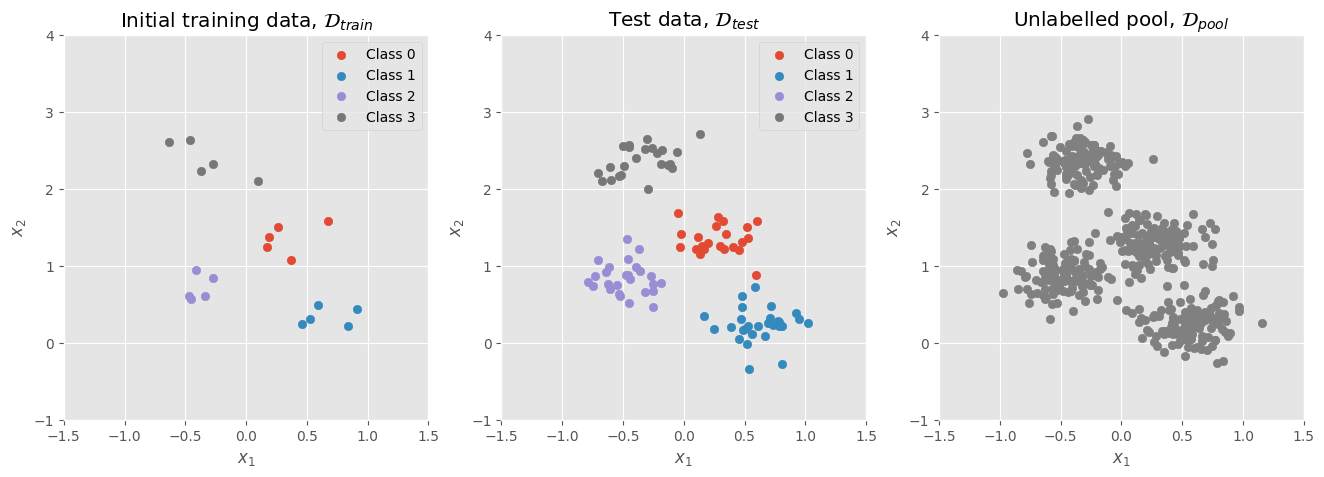

EPOCH 2000/2000: Train acc. = 1.0000 	 | Validation acc. = 1.0000 	 | Train loss = 0.0372 	 | Validation loss = 0.0691: 100%|██████████| 2000/2000 [00:12<00:00, 155.91it/s]

BEST EPOCH = 1999


In [10]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 5
N_test      = 100
N_pool      = 500
num_classes = 4

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_multiclass(N_initial_per_class=N_initial, N_test=N_test, N_pool=N_pool, num_classes=num_classes, noise=0.2)

# Plot the dataset partitions
plot_multiclass(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

# Set device
device = torch.device('cpu') #torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Xtrain  = torch.FloatTensor(Xtrain).to(device)
Xtest   = torch.FloatTensor(Xtest).to(device)
Xpool   = torch.FloatTensor(Xpool).to(device)

ytrain  = torch.LongTensor(ytrain).to(device)
ytest   = torch.LongTensor(ytest).to(device)
ypool   = torch.LongTensor(ypool).to(device)

# Define parameters
lr          = 1e-4
epochs      = 2000
val_step    = 1
seed        = 0

# Set device for model
model = SimpleLLLA(alpha=1., n_posterior_samples=5000, num_classes=num_classes)
model.to(device)

optimizer   = optim.Adam(model.parameters(), lr=lr)

train_model(model, optimizer, Xtrain, ytrain, Xtest, ytest, epochs, val_step, seed)

# "train" LLLA 
model.fit_LLLA(Xtrain, ytrain)

In [11]:
from src.methods.acquisition_functions import AcquisitionFunction
from src.methods.target_input_distribution import TargetInputDistribution
from typing import Tuple
import math

class EPIG(AcquisitionFunction):

    def __init__(self, query_n_points, target_input_distribution: TargetInputDistribution, n_posterior_samples: int = 1000, n_target_input_samples: int = 100, seed: int = 0):
        # Make target-input distribution accesible
        self.target_input_distribution = target_input_distribution

        # Set class-wide sampling parameters
        self.n_posterior_samples    = n_posterior_samples
        self.n_target_input_samples = n_target_input_samples
        self.seed                   = seed

        super().__init__(name='EPIG', query_n_points=query_n_points)

    def __call__(self, Xpool: np.ndarray, return_sorted: bool = True, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        K, M        = self.n_posterior_samples, self.n_target_input_samples

        # Sample x* values from the target input distribution
        Xstar                       = self.target_input_distribution.sample(self.n_target_input_samples, seed=self.seed)
        self.Xstar                  = Xstar

        # Extract predictive probabilities for target samples and all points in the pool by exploiting Monte Carlo sampling of the posterior
        posterior_pool_samples      = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed)
        posterior_target_samples    = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed)

        logprobs_pool               = torch.log_softmax(posterior_pool_samples, dim=0)[:, None, :, :, None]
        logprobs_target             = torch.log_softmax(posterior_target_samples, dim=0)[None, :, :, None, :]

        logprobs_joint              = logprobs_pool + logprobs_target
        logprobs_joint              = torch.logsumexp(logprobs_joint, dim=2) - math.log(K)
        probs_joint                 = torch.exp(logprobs_joint)

        logprobs_independent        = (torch.logsumexp(logprobs_pool, dim=2) - math.log(K)) + (torch.logsumexp(logprobs_target, dim=2) - math.log(K))
        log_term                    = logprobs_joint - logprobs_independent

        acq_scores                  = (probs_joint * log_term).sum(dim=[0, 1])
        acq_scores                  = acq_scores.mean(dim=-1)
        assert torch.all((acq_scores + 1e-6 >= 0) & (acq_scores - 1e-6 <= math.inf)).item(), "Acquisition scores are not valid!"
        
        # Sort values
        return self.order_acq_scores(acq_scores=acq_scores, return_sorted=return_sorted)
    
model.variance_factor   = 1.
model.predict_proba     = model.predict_posterior_proba

for mu in [[1.0, 0.0], [0.0, 1.0], [0.2, 1.5]]:
    with torch.no_grad():
        # Define acquisition function
        target_input_dist = MultivariateGaussian(mu=mu, Sigma=np.eye(2) / 10)

        # Define acquisition function
        acq_fun = EPIG(
            query_n_points=None, 
            target_input_distribution=target_input_dist,
            n_posterior_samples=1000,
            n_target_input_samples=100,
            seed=0
        )

        # Get acquisition function score and the items to query
        _, query_idxs   = acq_fun(Xpool, model=model)
        next_query      = Xpool[query_idxs[0]]

        # Visualize
        axs = plot_example(acq_fun, next_query, P=35, auto_zoom=False, zoom=([-1.5, 1.5], [-1, 4]))
        # axs[2].scatter(acq_fun.Xstar[:, 0], acq_fun.Xstar[:, 1], marker='s', s=50, color='k')
        # Plot target input distribution on top
        target_input_dist.plot_2D(ax=axs[2], zoom=([-1.5, 1.5], [-1, 4]))

        plt.tight_layout()
        plt.show()

In [9]:
# from src.methods.acquisition_functions import AcquisitionFunction
# from src.methods.target_input_distribution import TargetInputDistribution
# from typing import Tuple

# class GeneralEPIG(AcquisitionFunction):

#     def __init__(self, query_n_points, target_input_distribution: TargetInputDistribution, n_posterior_samples: int = 1000, n_target_input_samples: int = 100, seed: int = 0):
#         # Make target-input distribution accesible
#         self.target_input_distribution = target_input_distribution

#         # Set class-wide sampling parameters
#         self.n_posterior_samples    = n_posterior_samples
#         self.n_target_input_samples = n_target_input_samples
#         self.seed                   = seed

#         super().__init__(name='GeneralEPIG', query_n_points=query_n_points)

#     def __call__(self, Xpool: np.ndarray, return_sorted: bool = True, **kwargs) -> Tuple[np.ndarray, np.ndarray]:

#         # Sample x* values from the target input distribution
#         Xstar                   = self.target_input_distribution.sample(self.n_target_input_samples, seed=self.seed)
        
#         # Extract predictive probabilities for target samples and all points in the pool by exploiting Monte Carlo sampling of the posterior
#         # _, probs_pool  = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed)
#         # _, probs_targ  = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed)
#         posterior_pool_samples      = kwargs['model'].sample(np.vstack(Xpool), n_samples=self.n_posterior_samples, seed=self.seed).permute(1, 2, 0)
#         posterior_target_samples    = kwargs['model'].sample(np.vstack(Xstar), n_samples=self.n_posterior_samples, seed=self.seed).permute(1, 2, 0)

#         # pool_probs                  = torch.softmax(posterior_pool_samples, dim=0) #.mean(axis=1).T  
#         # targ_probs                  = torch.softmax(posterior_target_samples, dim=0)# .mean(axis=1).T  
        
#         # Define constants
#         num_classes = posterior_pool_samples.shape[2]
#         K, M        = self.n_posterior_samples, self.n_target_input_samples

#         log_probs_pool      = (posterior_pool_samples - torch.logsumexp(posterior_pool_samples, dim=2, keepdim=True))[:, :, None, :, None]
#         log_probs_target    = (posterior_target_samples - torch.logsumexp(posterior_target_samples, dim=2, keepdim=True))[:, None, :, None, :]
#         log_probs_joint     = log_probs_pool + log_probs_target
#         probs_joint         = torch.exp(log_probs_joint)

#         import math
#         log_numerator   = math.log(K) + torch.logsumexp(log_probs_joint, dim=0, keepdim=True)
#         log_denominator = torch.logsumexp(log_probs_pool, dim=0, keepdim=True) + torch.logsumexp(log_probs_target, dim=0, keepdim=True)
#         log_fraction    = log_numerator - log_denominator

#         acq_scores = (probs_joint.mean(dim=0, keepdim=True)  * log_fraction).sum(dim=[4, 3]).mean(dim=2).flatten()
        
#         # # Compute the joint term of the expression (summation on the numerator part of the fraction in the log)
#         # joint_term          = torch.tensor(np.array([[((pool_probs[c, :, :] * targ_probs[c_star, :, j][:, None]).sum(axis=0)).cpu().numpy() for j in range(M)] for c in range(num_classes) for c_star in range(num_classes)]))
#         # # Compute the independent term of the expression (summation on the denominator part of the fraction in the log)
#         # independent_term    = torch.tensor(np.array([[(pool_probs[c, :, :].sum(axis=0) * targ_probs[c_star, :, j].sum(axis=0)).cpu().numpy() for j in range(M)] for c in range(num_classes) for c_star in range(num_classes)]))
#         # # Compute log-term
#         # log_term            = np.log(K * joint_term) - np.log(independent_term)
#         # # Wrap it up and compute the final acquisition scores
#         # acq_scores          = 1/M * log_term.sum(axis=(1, 0))

#         # Sort values
#         return self.order_acq_scores(acq_scores=acq_scores, return_sorted=return_sorted)

In [102]:

# model.variance_factor   = 1.
# model.predict_proba     = model.predict_posterior_proba
# with torch.no_grad():
#     # Define acquisition function
#     target_input_dist = MultivariateGaussian(mu=[0, 0], Sigma=np.eye(2) / 4)

#     # Define acquisition function
#     acq_fun = GeneralEPIG(
#         query_n_points=None, 
#         target_input_distribution=target_input_dist,
#         n_posterior_samples=1000,
#         n_target_input_samples=100,
#     )

#     # Get acquisition function score and the items to query
#     _, query_idxs   = acq_fun(Xpool, model=model)
#     next_query      = Xpool[query_idxs[0]]

#     # Visualize
#     axs = plot_example(acq_fun, next_query, P=25, auto_zoom=False, zoom=([-5, 5], [-5, 5]))
#     # Plot target input distribution on top
#     target_input_dist.plot_2D(ax=axs[2], zoom=([-5, 5], [-5, 5]))

#     plt.tight_layout()
#     plt.show()

In [2]:
from collections import defaultdict
from typing import List
import pickle

import numpy as np
import pandas as pd

def combine_results(acq_functions: List, experiments: List[str], save_dir: str = "../reports/2D_toy", seeds=[0]):
    train_results, test_results = defaultdict(dict), defaultdict(dict)
    for i, acq_fun in enumerate(acq_functions):           
        for experiment in experiments:
            for j, seed in enumerate(seeds):

                with open(f'{save_dir}/{experiment}/{acq_fun}/seed{seed}/performance.pkl', 'rb') as f:
                    res         = pickle.load(f)
                    train_res   = np.array(res['train']).reshape(1, -1) if j == 0 else np.vstack([train_res, res['train']])
                    test_res    = np.array(res['test']).reshape(1, -1) if j == 0 else np.vstack([test_res, res['test']])
            
            if i == 0:
                train_results[experiment]['N_points']   = res['N_points']
                test_results[experiment]['N_points']    = res['N_points']

            train_results[experiment][acq_fun]          = np.mean(train_res, axis=0)
            test_results[experiment][acq_fun]           = np.mean(test_res, axis=0) 
            train_results[experiment][f'{acq_fun}_std'] = np.std(train_res, axis=0) / np.sqrt(train_res.shape[0])
            test_results[experiment][f'{acq_fun}_std']  = np.std(test_res, axis=0) / np.sqrt(test_res.shape[0])

    return train_results, test_results

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

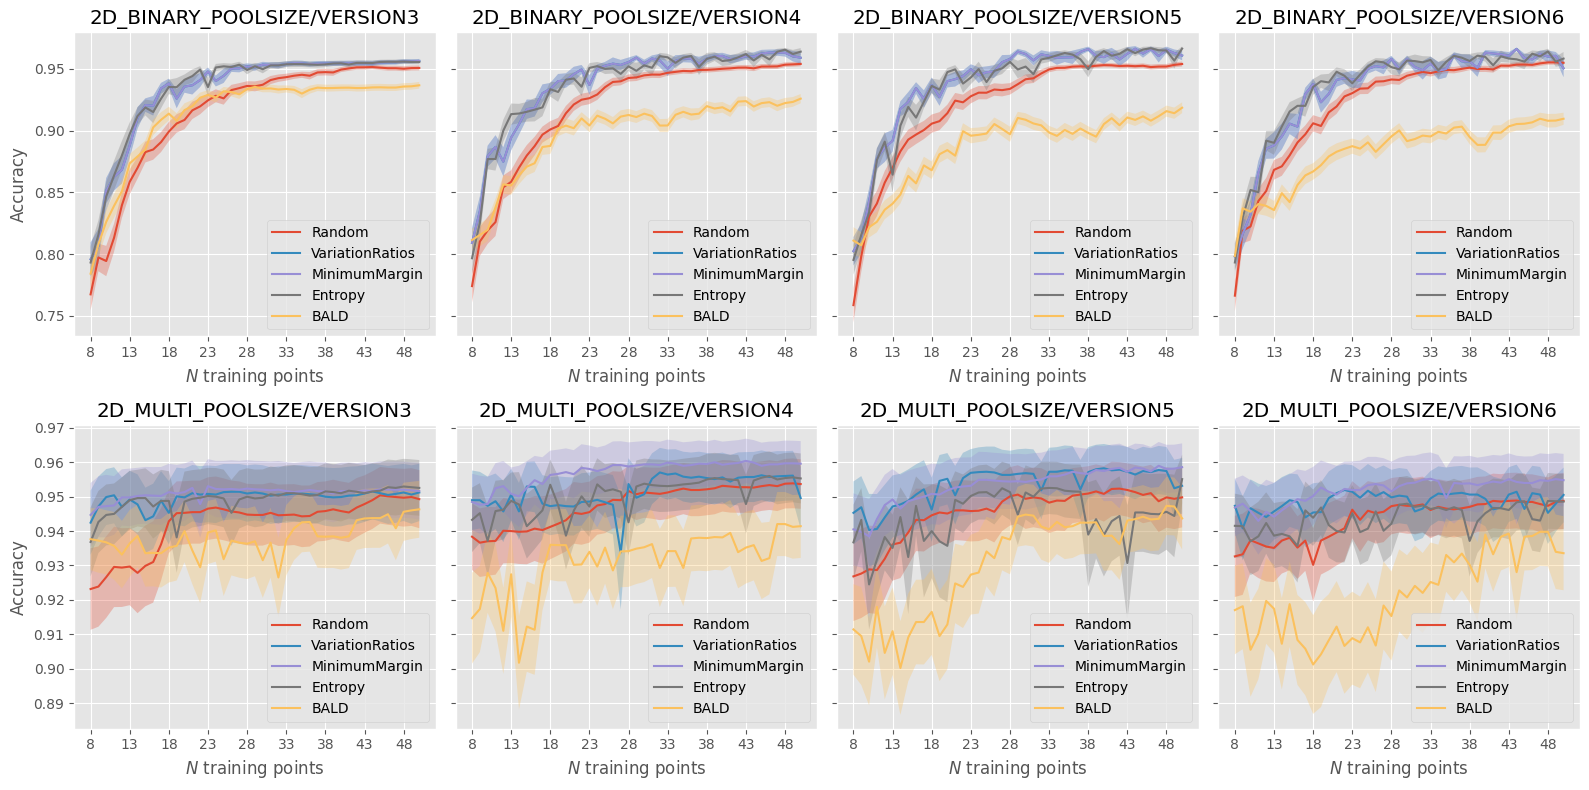

In [33]:
acq_functions           = ['Random', 'VariationRatios', 'MinimumMargin', 'Entropy', 'BALD']

seeds                   = np.arange(98)
experiments_binary      = ['2D_binary_poolsize/version3', '2D_binary_poolsize/version4', '2D_binary_poolsize/version5', '2D_binary_poolsize/version6']
_,  results_binary      = combine_results(acq_functions=acq_functions, experiments=experiments_binary, save_dir='../reports', seeds=seeds)

seeds                   = np.arange(49)
experiments_multiclass  = ['2D_multi_poolsize/version3', '2D_multi_poolsize/version4', '2D_multi_poolsize/version5'] #, '2D_multi_poolsize/version6']
_,  results_multiclass  = combine_results(acq_functions=acq_functions, experiments=experiments_multiclass, save_dir='../reports', seeds=seeds)


fig, axs        = plt.subplots(2, max(len(experiments_binary), len(experiments_multiclass)), sharey='row', figsize=(16, 8))
for j, (results, experiments) in enumerate([(results_binary, experiments_binary), (results_multiclass, experiments_multiclass)]):
    for i, experiment in enumerate(experiments):
        # Convert to pandas dataframe
        df_             = pd.DataFrame.from_dict(results[experiment])
        # Account for number of initial points in training set
        df_['N_points'] -= 4 if j == 0 else 8
        df_             = df_[8:]
        
        # Plot results case
        df_.plot(x='N_points', y=acq_functions, ax=axs[j, i])
        for acq_fun in acq_functions:
            axs[j, i].fill_between(
                df_['N_points'], 
                df_[acq_fun] - df_[f'{acq_fun}_std'], 
                df_[acq_fun] + df_[f'{acq_fun}_std'],
                alpha=0.3,
            )
        axs[j, i].set_ylabel('Accuracy')
        axs[j, i].set_xlabel('$N$ training points')
        axs[j, i].set_title(experiment.upper())
        axs[j, i].set_xticks(df_['N_points'][::5], df_['N_points'][::5])
        axs[j, i].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [17]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [25]:
probs = sigmoid(np.random.normal(loc=0, scale=np.sqrt(10), size=10000))

(array([2313.,  874.,  673.,  515.,  524.,  518.,  578.,  637.,  903.,
        2465.]),
 array([1.16256839e-06, 1.00001042e-01, 2.00000922e-01, 3.00000802e-01,
        4.00000682e-01, 5.00000562e-01, 6.00000441e-01, 7.00000321e-01,
        8.00000201e-01, 9.00000081e-01, 9.99999961e-01]),
 <BarContainer object of 10 artists>)

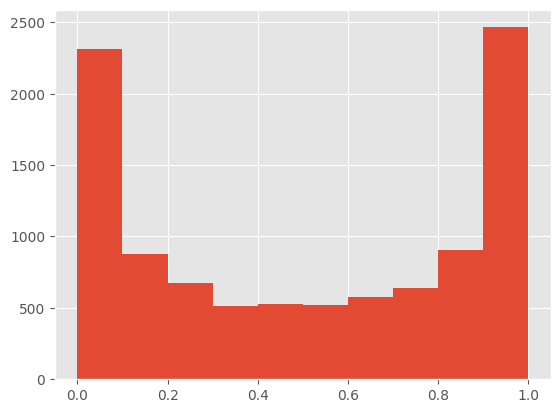

In [26]:
plt.hist(probs)

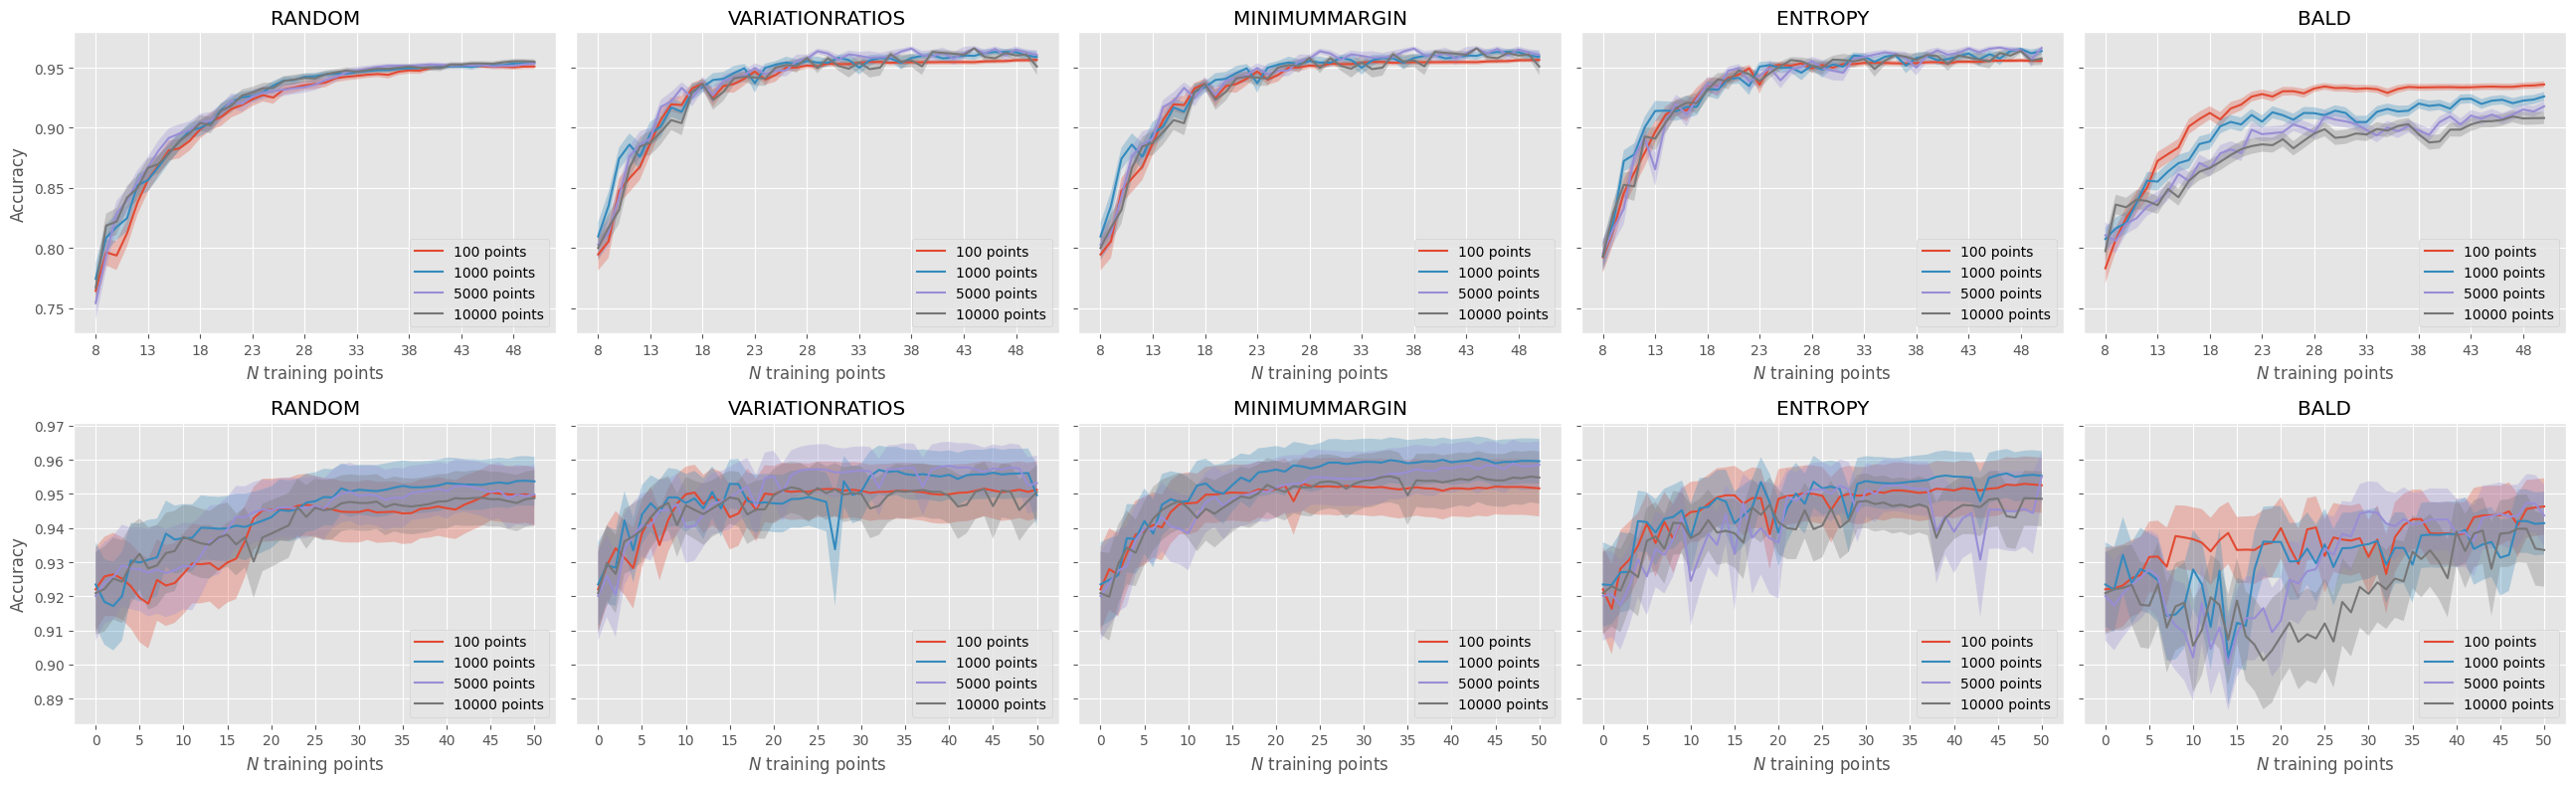

In [37]:
acq_functions           = ['Random', 'VariationRatios', 'MinimumMargin', 'Entropy', 'BALD']

seeds                   = np.arange(100)
experiments_binary      = ['2D_binary_poolsize/version3', '2D_binary_poolsize/version4', '2D_binary_poolsize/version5', '2D_binary_poolsize/version6']
_,  results_binary      = combine_results(acq_functions=acq_functions, experiments=experiments_binary, save_dir='../reports', seeds=seeds)

seeds                   = np.arange(49)
experiments_multiclass  = ['2D_multi_poolsize/version3', '2D_multi_poolsize/version4', '2D_multi_poolsize/version5', '2D_multi_poolsize/version6']
_,  results_multiclass  = combine_results(acq_functions=acq_functions, experiments=experiments_multiclass, save_dir='../reports', seeds=seeds)

versionmap = {'version3': '100 points', 'version4': '1000 points', 'version5': '5000 points', 'version6': '10000 points'}

fig, axs        = plt.subplots(2, 5, figsize=(26, 8), sharey='row')
for j, (results, experiments) in enumerate([(results_binary, experiments_binary), (results_multiclass, experiments_multiclass)]):
    for _, experiment in enumerate(experiments):
        # Convert to pandas dataframe
        df_             = pd.DataFrame.from_dict(results[experiment])
        # Account for number of initial points in training set
        df_['N_points'] -= 4 if j == 0 else 8
        if j == 0:
            df_             = df_[8:]

        for i, acq_fun in enumerate(acq_functions):

            # Plot results case
            df_[['N_points', acq_fun]].plot(x='N_points', y=acq_fun, ax=axs[j, i], label=versionmap[experiment.split("/")[1]])
            axs[j, i].fill_between(
                df_['N_points'], 
                df_[acq_fun] - df_[f'{acq_fun}_std'], 
                df_[acq_fun] + df_[f'{acq_fun}_std'],
                alpha=0.3,
            )
            axs[j, i].set_ylabel('Accuracy')
            axs[j, i].set_xlabel('$N$ training points')
            axs[j, i].set_title(acq_fun.upper())
            axs[j, i].set_xticks(df_['N_points'][::5], df_['N_points'][::5])
            axs[j, i].legend(loc='lower right')

plt.tight_layout()
plt.show()